# Q-Learning vs SARSA and Q-Learning extensions

Temporal-difference (TD) learning is a combination of these two approaches. It learns directly from experience by sampling, but also bootstraps. This represents a breakthrough in capability that allows agents to learn optimal strategies in any environment. Prior to this point learning was so slow it made problems intractable or you needed a full model of the environment.

In 1989, an implementation of TD learning called Q-learning made it easier for mathematicians to prove convergence. This algorithm is credited with kick-starting the excitement in RL.

SARSA was developed shortly after Q-learning to provide a more general solution to TD learning. The main difference from Q-learning is the lack of argmax in the delta. Instead it calculates the expected return by averaging over all runs (in an online manner).

Two fundamental RL algorithms, both remarkably useful, even today. One of the primary reasons for their popularity is that they are simple, because by default they only work with discrete state and action spaces. Of course it is possible to improve them to work with continuous state/action spaces, but consider discretizing to keep things rediculously simple.

## Setup

In [ ]:
!pip install pygame==1.9.6 pandas==1.0.5 matplotlib==3.2.1
!pip install --upgrade git+git://github.com/david-abel/simple_rl.git@77c0d6b910efbe8bdd5f4f87337c5bc4aed0d79c > /dev/null

In [ ]:
import numpy as np
import pandas as pd
import math
import json
import os
from collections import defaultdict

# Other imports.
from simple_rl.agents import Agent, QLearningAgent, RandomAgent
from simple_rl.agents import DoubleQAgent, DelayedQAgent
from simple_rl.tasks import GridWorldMDP
from simple_rl.run_experiments import run_single_agent_on_mdp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
matplotlib.use("agg", force=True)

In [ ]:
%matplotlib inline

## SARSA agent

In [ ]:
class SARSAAgent(QLearningAgent):
    def __init__(self, actions, goal_reward, name="SARSA",
                 alpha=0.1, gamma=0.99, epsilon=0.1, explore="uniform", anneal=False):
        self.goal_reward = goal_reward
        QLearningAgent.__init__(
            self,
            actions=list(actions),
            name=name,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            explore=explore,
            anneal=anneal)

    def policy(self, state):
        return self.get_max_q_action(state)

    def act(self, state, reward, learning=True):
        '''
        This is mostly the same as the base QLearningAgent class. Except that
        the update procedure now generates the action.
        '''
        if learning:
            action = self.update(
                self.prev_state, self.prev_action, reward, state)
        else:
            if self.explore == "softmax":
                # Softmax exploration
                action = self.soft_max_policy(state)
            else:
                # Uniform exploration
                action = self.epsilon_greedy_q_policy(state)

        self.prev_state = state
        self.prev_action = action
        self.step_number += 1

        # Anneal params.
        if learning and self.anneal:
            self._anneal()

        return action

    def update(self, state, action, reward, next_state):
        '''
        Args:
            state (State)
            action (str)
            reward (float)
            next_state (State)
        Summary:
            Updates the internal Q Function according to the Bellman Equation
            using a SARSA update
        '''

        if self.explore == "softmax":
            # Softmax exploration
            next_action = self.soft_max_policy(next_state)
        else:
            # Uniform exploration
            next_action = self.epsilon_greedy_q_policy(next_state)

        # Update the Q Function.
        prev_q_val = self.get_q_value(state, action)
        next_q_val = self.get_q_value(next_state, next_action)
        self.q_func[state][action] = prev_q_val + self.alpha * \
            (reward + self.gamma * next_q_val - prev_q_val)
        return next_action

## Experiment

Basically I’m training an agent for a maximum of 100 steps, for 500 episodes, averaging over 100 repeats.

Feel free to tinker with the settimgs.

In [ ]:
np.random.seed(42)
instances = 100
n_episodes = 500
alpha = 0.1
epsilon = 0.1

# Setup MDP, Agents.
mdp = GridWorldMDP(
    width=10, height=4, init_loc=(1, 1), goal_locs=[(10, 1)],
    lava_locs=[(x, 1) for x in range(2, 10)], is_lava_terminal=True, gamma=1.0, walls=[], slip_prob=0.0, step_cost=1.0, lava_cost=100.0)

print("Q-Learning")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = QLearningAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha)
    # mdp.visualize_learning(ql_agent, delay=0.0001)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("q_learning_cliff_rewards.json")

print("SARSA")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    sarsa_agent = SARSAAgent(
        mdp.get_actions(),
        goal_reward=0,
        epsilon=epsilon,
        alpha=alpha)
    # mdp.visualize_learning(sarsa_agent, delay=0.0001)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        sarsa_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("sarsa_cliff_rewards.json")

Q-Learning
  Instance 0 of 100.
  Instance 1 of 100.
  Instance 2 of 100.
  Instance 3 of 100.
  Instance 4 of 100.
  Instance 5 of 100.
  Instance 6 of 100.
  Instance 7 of 100.
  Instance 8 of 100.
  Instance 9 of 100.
  Instance 10 of 100.
  Instance 11 of 100.
  Instance 12 of 100.
  Instance 13 of 100.
  Instance 14 of 100.
  Instance 15 of 100.
  Instance 16 of 100.
  Instance 17 of 100.
  Instance 18 of 100.
  Instance 19 of 100.
  Instance 20 of 100.
  Instance 21 of 100.
  Instance 22 of 100.
  Instance 23 of 100.
  Instance 24 of 100.
  Instance 25 of 100.
  Instance 26 of 100.
  Instance 27 of 100.
  Instance 28 of 100.
  Instance 29 of 100.
  Instance 30 of 100.
  Instance 31 of 100.
  Instance 32 of 100.
  Instance 33 of 100.
  Instance 34 of 100.
  Instance 35 of 100.
  Instance 36 of 100.
  Instance 37 of 100.
  Instance 38 of 100.
  Instance 39 of 100.
  Instance 40 of 100.
  Instance 41 of 100.
  Instance 42 of 100.
  Instance 43 of 100.
  Instance 44 of 100.
  Instanc

## Results
Now you can plot the results for each of the agents.

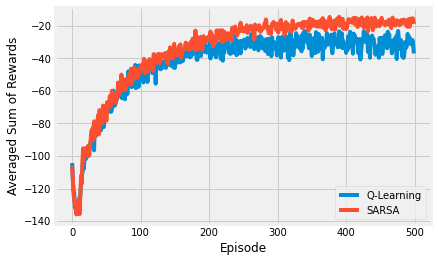

In [ ]:
data_files = [("Q-Learning", "q_learning_cliff_rewards.json"),
              ("SARSA", "sarsa_cliff_rewards.json")]

fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Averaged Sum of Rewards')
ax.legend(loc='lower right')
plt.show()

## Delayed Q-learning vs. Double Q-learning vs. Q-Learning
Delayed Q-learning and double Q-learning are two extensions to Q-learning that are used throughout RL, so it’s worth considering them in a simple form. Delayed Q-learning simply delays any estimate until there is a statistically significant sample of observations. Slowing update with an exponentially weighted moving average is a similar strategy. Double Q-learning includes two Q-tables, in essence two value estimates, to reduce bias.

In [ ]:
np.random.seed(42)
instances = 10
n_episodes = 1000
alpha = 0.1
epsilon = 0.1

# Setup MDP, Agents.
mdp = GridWorldMDP(
    width=10, height=4, init_loc=(1, 1), goal_locs=[(10, 1)],
    lava_locs=[(x, 1) for x in range(2, 10)], is_lava_terminal=True, gamma=1.0, walls=[], slip_prob=0.0, step_cost=1.0, lava_cost=100.0)

print("Q-Learning")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = QLearningAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("q_learning_cliff_rewards.json")

print("Double-Q-Learning")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = DoubleQAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha)
    # mdp.visualize_learning(ql_agent, delay=0.0001)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("double_q_learning_cliff_rewards.json")

print("Delayed-Q-Learning")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = DelayedQAgent(
        mdp.get_actions(),
        epsilon1=alpha)
    # mdp.visualize_learning(ql_agent, delay=0.0001)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("delayed_q_learning_cliff_rewards.json")

Q-Learning
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.
Double-Q-Learning
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.
Delayed-Q-Learning
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.


Below is the code to visualise the training of the three agents. As usual, there are a maximum of 100 steps, over 200 episodes, averaged over 10 repeats. Feel free to tinker with those settings.

The results show the differences between the three algorithms. In general, double Q-learning tends to be more stable than Q-learning. And delayed Q-learning is more robust against outliers, but can be problematic in environments with larger state/action spaces. I.e. you might have to wait for a long time to get the required number of samples for a particular state-action pair, which will delay further exploration.

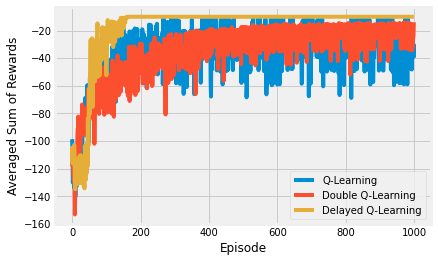

In [ ]:
data_files = [("Q-Learning", "q_learning_cliff_rewards.json"),
              ("Double Q-Learning", "double_q_learning_cliff_rewards.json"),
              ("Delayed Q-Learning", "delayed_q_learning_cliff_rewards.json")]
fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Averaged Sum of Rewards')
ax.legend(loc='lower right')
plt.show()